In [227]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import networkx as nx
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import requests
import tempfile
import logging

In [228]:
#df = pd.read_csv("data/04022021.csv")
#df = pd.read_csv("data/05022021.csv")
#df = pd.read_csv("data/job_results_second_run.csv")
#df = pd.read_csv("data/job_results.csv")
#df = pd.read_csv("data/15022021.csv")
df1 = pd.read_csv("data/job_results_21_02_22_2156.csv")
df2 = pd.read_csv("data/job_results_21_02_23_0842.csv")

df = pd.concat([df1,df2], ignore_index=True)
#df = pd.read_csv("data/beta_one.csv")
df = pd.read_csv("data/job_results.csv")
df.head()

,Unnamed: 0,config/num_nodes,config/edge_density,config/discrete_node_ratio,config/discrete_signal_to_noise_ratio,config/min_discrete_value_classes,config/max_discrete_value_classes,config/continuous_noise_std,config/continuous_beta_mean,config/continuous_beta_std,...,gd_compare/error_types/true_positives/rate,gd_compare/error_types/true_positives/edges,gd_compare/hamming_distance,gd_compare/hamming_distance_pcdag,experiment_config/parameters/discrete_limit,experiment_config/algorithm/valid_parameters/discrete_limit/type,experiment_config/algorithm/valid_parameters/discrete_limit/minimum,experiment_config/algorithm/valid_parameters/discrete_limit/default,experiment_config/algorithm/valid_parameters/cores/required,result/meta_results/discrete_limit
0,0,5,0.2,0.0,0.9,2,3,0.2,1.0,0.0,...,0.0,[],0.15,0.1,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5,0.2,0.0,0.9,2,3,0.2,1.0,0.0,...,1.0,"[[4, 5]]",0.05,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,0.2,0.0,0.9,2,3,0.2,1.0,0.0,...,1.0,"[[4, 5]]",0.05,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,5,0.2,0.0,0.9,2,3,0.2,1.0,0.0,...,1.0,"[[4, 5]]",0.05,0.1,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5,0.2,0.0,0.9,2,3,0.2,1.0,0.0,...,1.0,"[[4, 5]]",0.05,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [229]:
dataset_config = [c for c in df.columns if c.startswith("config")]
gd_compare = [c for c in df.columns if c.startswith("gd_compare") and not c.endswith("edges")]
result = ['result/dataset_loading_time', 'result/execution_time', 'result/meta_results/sampling_factor']
experiment_config = ["experiment_config/parameters/alpha", "experiment_config/algorithm/function", "experiment_config/algorithm/package", "experiment_config/name"]

In [230]:
# Selecting relevant columns
columns = dataset_config + gd_compare + experiment_config + result

In [231]:
#Renaming columns
renaming_dict = {}
for c in columns:
    name_split = c.split("/")
    name = name_split[-1]
    
    if name == "rate":
        name = name_split[-2]
        
    renaming_dict[c] = name

cleaned_df = df[columns].rename(columns=renaming_dict)

In [232]:
continous_data = cleaned_df[cleaned_df.discrete_node_ratio == 0]
mix_data = cleaned_df[cleaned_df.discrete_node_ratio > 0][cleaned_df.discrete_node_ratio < 1]
discrete_data = cleaned_df[cleaned_df.discrete_node_ratio == 1]

<ipython-input-232-4a95f828dd7a>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mix_data = cleaned_df[cleaned_df.discrete_node_ratio > 0][cleaned_df.discrete_node_ratio < 1]


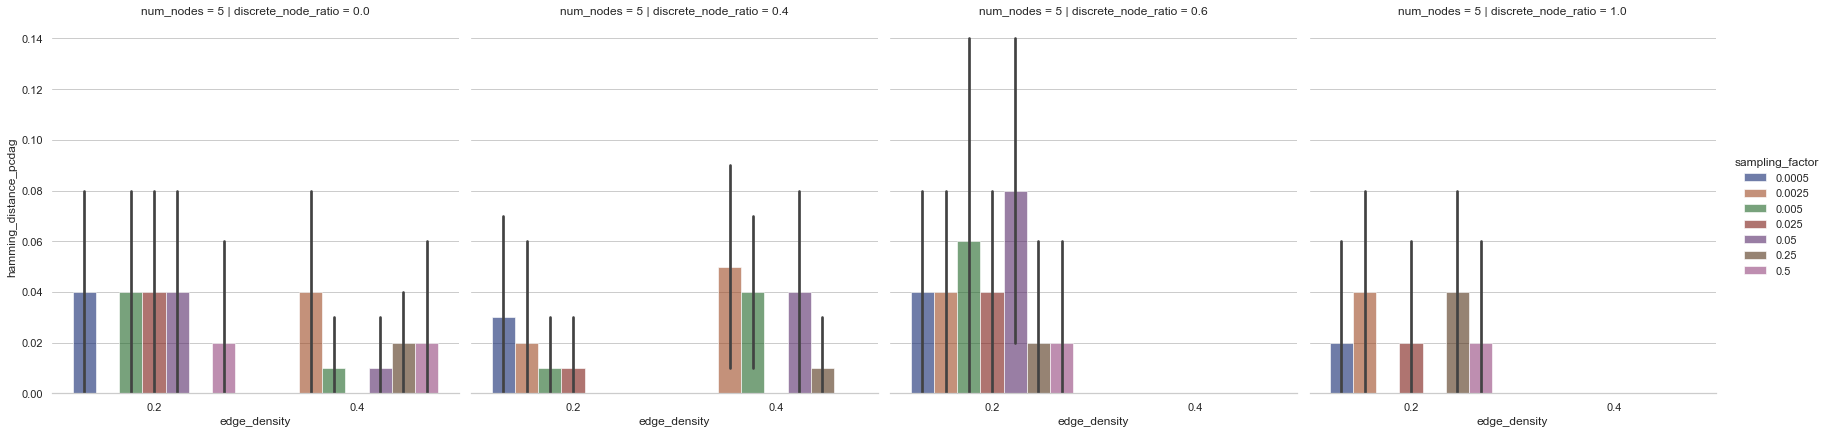

In [233]:
["num_nodes", "edge_density", "num_samples", "alpha", "discrete_node_ratio"]
metrics = ["hamming_distance_pcdag"] #"graph_edit_distance", "mean_jaccard_coefficient"]
plotted_data = cleaned_df[(cleaned_df.alpha == 0.05)]

for metric in metrics:
    
    x="edge_density"
    y=metric
    hue="sampling_factor"
    row="num_nodes"
    col="discrete_node_ratio"
    
    g = sns.catplot(
        data=plotted_data,
        kind="bar",
        x=x,
        y=metric,
        hue=hue,
        row=row,
        col=col,
        palette="dark",
        alpha=.6,
        height=6,
        facet_kws=dict(margin_titles=True),
    )
    #plt.title(f'Metric: {metric}, x={x}, y={y}, hue={hue}, row={row}, col={col}')
    display(g.despine(left=True))

In [234]:
edge_density = 0.6
num_nodes = 5
discrete_node_ratio = 0.4

filtered_df = df[
    (df["config/edge_density"] == edge_density) &
    (df["config/num_nodes"] == num_nodes) &
    (df["config/discrete_node_ratio"] == discrete_node_ratio)
]
display(filtered_df.head()[["experiment_config/dataset"]])
network_data = df[["result/job_id",  "result/id", "experiment_config/dataset", "result/meta_results/sampling_factor", "gd_compare/hamming_distance", "config/edge_density", "config/discrete_node_ratio", "config/num_nodes"]]

,experiment_config/dataset


In [235]:
retry_strategy = Retry(
    total=3,
    status_forcelist=[429, 500, 502, 503, 504],
    method_whitelist=["GET", "PUT", "DELETE", "OPTIONS"],
    backoff_factor=10
)
adapter = HTTPAdapter(max_retries=retry_strategy)
http = requests.Session()
http.mount("http://", adapter)

In [236]:
API_HOST = "http://galileo.eaalab.hpi.uni-potsdam.de:5000"
#API_HOST = "http://localhost:5000"
API_RESULT_GRAPH = lambda result_id : f"{API_HOST}/api/result/{result_id}/export?format=GML"
API_GROUND_TRUTH_GRAPH = lambda dataset_id : f"{API_HOST}/api/dataset/{dataset_id}/ground-truth?format=GML"

def get_est_graph(result_id: int, tmp_path="./est_graph.gml"):
    response_graph = http.get(API_RESULT_GRAPH(result_id))

    if response_graph.status_code != 200:
        error_msg = f"API Request to {API_RESULT_GRAPH(result_id)} failed."
        raise Exception(error_msg)

    with open(tmp_path, 'wb') as f:
        f.write(response_graph.content)
        
    return nx.read_gml(tmp_path)

def get_gt_graph(dataset_id: int, tmp_path="./gt-download.gml"):
    response_graph = http.get(API_GROUND_TRUTH_GRAPH(dataset_id))

    if response_graph.status_code != 200:
        error_msg = f"API Request to {API_GROUND_TRUTH_GRAPH(dataset_id)} failed."
        logging.error(error_msg)
        raise Exception(error_msg)
        
    with open(tmp_path, 'wb') as f:
        f.write(response_graph.content)

    return nx.read_gml(tmp_path)

In [237]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def f(edge_density: float,
      num_nodes: int,
      discrete_node_ratio: float,
      sampling_factor: int):
    
    filtered_df = df[
        (df["config/edge_density"] == edge_density) &
        (df["config/num_nodes"] == num_nodes) &
        (df["config/discrete_node_ratio"] == discrete_node_ratio) &
        (df["result/meta_results/sampling_factor"] == sampling_factor)
    ]
    filtered_df = filtered_df[["result/job_id",  "result/id", "experiment_config/dataset", "result/meta_results/sampling_factor", "gd_compare/hamming_distance", "config/edge_density", "config/discrete_node_ratio", "config/num_nodes"]]
    display(filtered_df)

    dataset_id = filtered_df.iat[0, 2]
    print(f"dataset: {dataset_id}")
    gt_graph = get_gt_graph(dataset_id)
    
    plot_index = 161
    plt.figure(figsize=(24, 6))
    plt.subplot(plot_index)
    nx.draw_shell(gt_graph, with_labels = True)
    plt.title("Ground truth")
    #plt.show()
    
    current_plot_index = plot_index 
    #display(nx.draw_spring(gt_graph, with_labels = True))
    for i, row in filtered_df.iterrows():
        current_plot_index += 1
        result_id = int(row["result/id"])
        est_graph = get_est_graph(result_id)
        
        #print(current_plot_index)
        plt.subplot(current_plot_index)
        nx.draw_shell(est_graph, with_labels = True)
        plt.title(f"Result id: {result_id}")

    plt.show()
    #plt.figsize(15,15)
    
interact(f,
    edge_density=network_data["config/edge_density"].unique(),
    sampling_factor=network_data["result/meta_results/sampling_factor"].unique(),
    num_nodes=network_data["config/num_nodes"].unique(),
    discrete_node_ratio=network_data["config/discrete_node_ratio"].unique(),
)

interactive(children=(Dropdown(description='edge_density', options=(0.2, 0.4), value=0.2), Dropdown(descriptio…

<function __main__.f(edge_density: float, num_nodes: int, discrete_node_ratio: float, sampling_factor: int)>